# CTSegNet 2D Feature Extraction (measurements from segmented image)  

Notebook Author: Aniket Tekawade, Argonne National Laboratory, atekawade@anl.gov  

### Documentation Link:  

https://ctsegnet.readthedocs.io/en/latest/source/api/seg_utils.html#ct_segnet.seg_utils.FeatureExtraction2D  

In [1]:
%matplotlib inline

import sys
import os
import numpy as np
import time

import matplotlib.pyplot as plt
import matplotlib as mpl

# from ct_segnet.data_utils import data_io
from ct_segnet.data_utils.data_io import DataFile
from ct_segnet import viewer
from ct_segnet import seg_utils
from tqdm import tqdm

from ct_segnet.data_utils import patch_maker_3D as PM3D
from ct_segnet.data_utils.data_io import Parallelize
from ct_segnet.seg_utils import Segmenter

figw = 8
import seaborn as sns
sns.set(font_scale = 1)
import time

In [2]:
model_path = "/home/atekawade/DataArchive3/Deep_Segmenting/model_repo"
model_name = "M_h01_242_256.hdf5"
model_filename = os.path.join(model_path, model_name)

In [3]:
csv_path = "/data02/MyArchive/aisteer_3Dencoders/data_TomoTwin/datalist_test.csv"

In [4]:
def make_ellipse(img_shape, rad = 256, ea = 1.0, isvoid = True):
    
    ptsy = np.arange(-img_shape[0]//2, img_shape[0]//2)
    ptsx = np.arange(-img_shape[1]//2, img_shape[1]//2)    
    
    yy, xx = np.meshgrid(ptsy, ptsx, indexing = 'ij')
    dist = np.sqrt(yy**2/ea**2 + xx**2)
    
    if isvoid:
        return (dist > rad).astype(np.uint8)
    else:
        return (dist < rad).astype(np.uint8)    

In [5]:
ea = 2.0
t1 = 5
t2 = 3
t3 = 3
ea_vals = np.concatenate([np.ones(t1), np.linspace(1,ea,t2), ea*np.ones(t3)], axis = 0)
nsteps = len(ea_vals)

Text(0, 0.5, 'ellipticity')

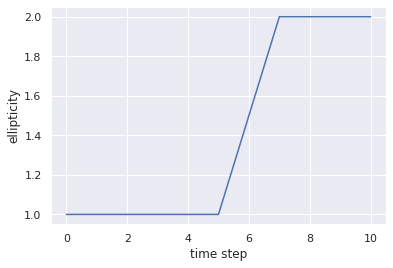

In [6]:
plt.plot(ea_vals)
plt.xlabel("time step")
plt.ylabel("ellipticity")

In [7]:
from ct_segnet.seg_utils import FeatureExtraction2D

In [8]:
# Example definition of plug-in measurement code
def measurement(seg_img):
    
    '''
    Parameters  
    ----------  
    seg_img : np.array  
        2D binarized image (semantic segmentation map)  
    
    Returns
    -------
    features : np.array  
        array of shape (nfeatures,)
    '''
    # measure stuff
    features = np.zeros(3)
    return features

In [9]:
img_shape = (960,960)
ndims = 2
max_patches = (2,2)
overlap = 20

def measurement(seg_img):
    return np.asarray([np.sum(seg_img), np.std(seg_img)])
    
fe = FeatureExtraction2D(model_filename = model_filename, \
                         max_patches = max_patches, \
                         overlap = overlap)

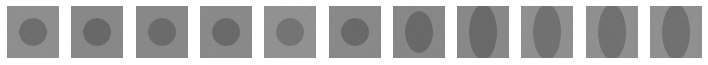

In [10]:
niters = 10 # number of times to repeat operation for average time estimate
imgs = [make_ellipse(img_shape, rad = 256, ea = ea) for ea in ea_vals]
imgs = [img + np.random.normal(0, 0.8, img.shape) for img in imgs]

fig, ax = plt.subplots(1,nsteps, figsize = (10,6))
for ii in range(len(ax)):
    ax.flat[ii].imshow(imgs[ii], cmap = 'gray')
    ax.flat[ii].axis('off')
fig.tight_layout()

In [11]:
idx = 5
features = fe.extract_measurement(imgs[idx], measurement)
features[0]

719987.0

In [12]:
def get_time(imgs, fe, measurement):

    time_series = np.zeros((nsteps, ndims))
    times = []
    for ii, img in enumerate(imgs):


        for jj in range(niters):

            t_start = time.time()
            time_series[ii, :] = fe.extract_measurement(img, measurement)
            t_end = time.time()
            times.append(t_end-t_start)
    avg_time = 1000.0*np.mean(times)
#     print("Average time: %.2f ms"%(avg_time)  
    return avg_time

In [13]:
img_sizes = [512, 960, 1920, 2500]
niters = 5 # number of times to repeat operation for average time estimate

fe = FeatureExtraction2D(model_filename = model_filename, \
                         max_patches = max_patches, \
                         overlap = overlap)

times_imsize = []
for img_size in img_sizes:
    img_shape = (img_size,img_size)
    
    imgs = [make_ellipse(img_shape, rad = 256, ea = ea) for ea in ea_vals]
    imgs = [img + np.random.normal(0, 0.8, img.shape) for img in imgs]
    
    this_time = get_time(imgs, fe, measurement)
    times_imsize.append(this_time)
    print("Average time: %.2f ms"%this_time)           

Average time: 55.95 ms
Average time: 52.29 ms
Average time: 74.14 ms
Average time: 114.73 ms


Text(0, 0.5, 'time (milliseconds)')

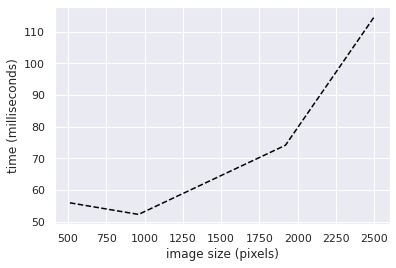

In [14]:
plt.plot(img_sizes, times_imsize, '--', color = 'black')
plt.xlabel("image size (pixels)")
plt.ylabel("time (milliseconds)")

## Scaling with max patches  

In [15]:
n_patch_list = [1, 2, 3, 4, 5, 6]
niters = 5 # number of times to repeat operation for average time estimate
img_shape = (1920,1920)

fe = FeatureExtraction2D(model_filename = model_filename, \
                         max_patches = max_patches, \
                         overlap = overlap)
times_patching = []
for n_patch in n_patch_list:
    
    fe.max_patches = (n_patch, n_patch)
    imgs = [make_ellipse(img_shape, rad = 256, ea = ea) for ea in ea_vals]
    imgs = [img + np.random.normal(0, 0.8, img.shape) for img in imgs]
    
    this_time = get_time(imgs, fe, measurement)
    times_patching.append(this_time)
    print("Average time: %.2f ms"%this_time)           

Average time: 84.52 ms
Average time: 86.89 ms
Average time: 100.35 ms
Average time: 123.72 ms
Average time: 157.59 ms
Average time: 237.21 ms


Text(0, 0.5, 'time (milliseconds)')

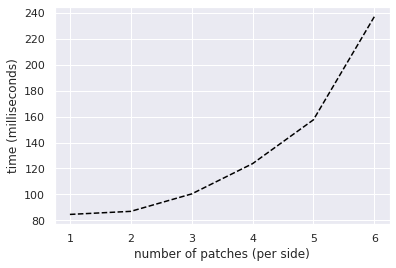

In [16]:
plt.plot(n_patch_list, times_patching, '--', color = 'black')
plt.xlabel("number of patches (per side)")
plt.ylabel("time (milliseconds)")

In [17]:
time.ctime()

'Thu Feb 18 04:48:49 2021'

The end!